This is a good ( **99% correct**) prediction for so-so.csv Data (5 input and 1 output). this page made from this Colab Page:

> Indented block



https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/time-series-rnn-full-predict.ipynb#scrollTo=WJJcT-mZh915


In [59]:

import os,sys

sys.path.insert(0,'/content/')
if not os.path.exists("/root/.ipython/ocr.py"):
    from subprocess import run
    from shlex import split

    shellCmd = "wget -qq https://raw.githubusercontent.com/biplobsd/OneClickRun/master/res/ocr.py \
                    -O /content/ocr.py"
    run(split(shellCmd))
from ocr import runSh

def runShT(args):
    return runSh(args, output=True)
runShT('bash simple_shell_script.sh')

bash: simple_shell_script.sh: No such file or directory


In [60]:
%%writefile simple_shell_script2.sh
Current_dir=$PWD
echo "current dir is ${Current_dir}"
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp '/content/gdrive/MyDrive/Amir Farzin Project/so-so.csv' /content/stock-prediction
# !wget https://transfer.sh/o5273/so-so.csv
echo "cd ${Current_dir}"
cd ${Current_dir}//stock-prediction

git clone https://github.com/So-AI-love/Test_NN
unzip -o  "${Current_dir}/Test_NN/so-so.zip" -d "${Current_dir}/Test_NN"
cp "${Current_dir}/Test_NN/so-so.csv" "${Current_dir}/"

Overwriting simple_shell_script2.sh


In [61]:
!pwd 

/content


In [62]:
runShT('bash simple_shell_script2.sh')

current dir is /content
cd /content
simple_shell_script2.sh: line 8: cd: /content//stock-prediction: No such file or directory
fatal: destination path 'Test_NN' already exists and is not an empty directory.
Archive:  /content/Test_NN/so-so.zip
inflating: /content/Test_NN/so-so.csv


In [63]:
import pandas as pd
# data_dir = "https://dlsun.github.io/pods/data/"
# df_ames = pd.read_csv(data_dir + "AmesHousing.txt", sep="\t")
# df_ames.head()

In [64]:
df = pd.read_csv('so-so.csv')
df.head()


,time,-1-,-2-,-3-,-4-,-5-,out
0,25:32.2,-8.0,0.018727,1.334451,60.080002,37.026861,15147.67255
1,25:32.3,-8.0,0.018305,1.344409,60.080002,37.011600,15027.05899
2,25:32.4,-8.0,0.013568,1.322260,59.820000,37.011600,15270.12537
3,25:32.5,-8.0,0.015240,1.330974,59.820000,37.011600,15162.10324
4,25:32.6,-8.0,0.014344,1.329409,59.820000,37.011600,15173.13050


In [65]:
import re, regex
ddd=df['time'].str
df['day_of_week']= ddd.split('.').str[-1]
df['time']= ddd.split('.').str[0]
df['day_of_week']=pd.to_datetime(df['day_of_week'], format='%H:%M', errors='ignore') #
# df=df[['time','day_of_week','-1-','-2-','-3-','-4-','-5-','out']]
df=df[['-1-','-2-','-3-','-4-','-5-','out']]
df.head()

,-1-,-2-,-3-,-4-,-5-,out
0,-8.0,0.018727,1.334451,60.080002,37.026861,15147.67255
1,-8.0,0.018305,1.344409,60.080002,37.011600,15027.05899
2,-8.0,0.013568,1.322260,59.820000,37.011600,15270.12537
3,-8.0,0.015240,1.330974,59.820000,37.011600,15162.10324
4,-8.0,0.014344,1.329409,59.820000,37.011600,15173.13050


# Forecasting Time Series data

* Idea and some code taken from, and also OPSD time series data set explained here: https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
* Some code and approaches from: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
* Nice tutorial: https://www.tensorflow.org/beta/tutorials/text/time_series

In [66]:
%matplotlib inline

import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

In [67]:
import pandas as pd
import numpy as np

In [68]:
# for local
# url = 'opsd_germany_daily.csv'

# for colab
url = 'https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'

# time_series_df = pd.read_csv(url, 
#                              sep=',', 
#                              index_col=0, # you can use the date as the index for pandas
#                              parse_dates=[0]) # where is the time stamp?

time_series_df=df;


In [69]:
time_series_df.head()

,-1-,-2-,-3-,-4-,-5-,out
0,-8.0,0.018727,1.334451,60.080002,37.026861,15147.67255
1,-8.0,0.018305,1.344409,60.080002,37.011600,15027.05899
2,-8.0,0.013568,1.322260,59.820000,37.011600,15270.12537
3,-8.0,0.015240,1.330974,59.820000,37.011600,15162.10324
4,-8.0,0.014344,1.329409,59.820000,37.011600,15173.13050


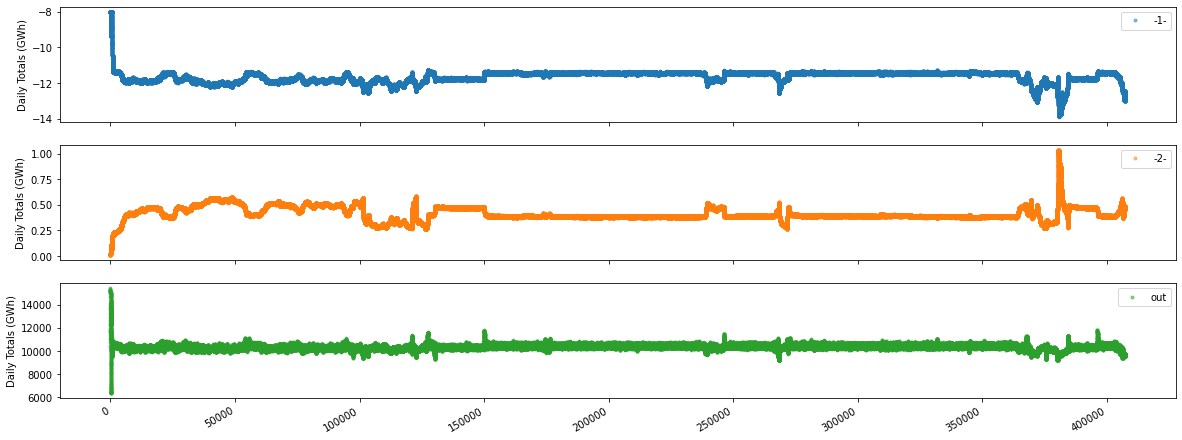

In [70]:
# cols_plot = ['Consumption', 'Solar', 'Wind']

cols_plot = ['-1-', '-2-', 'out']

axes = time_series_df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

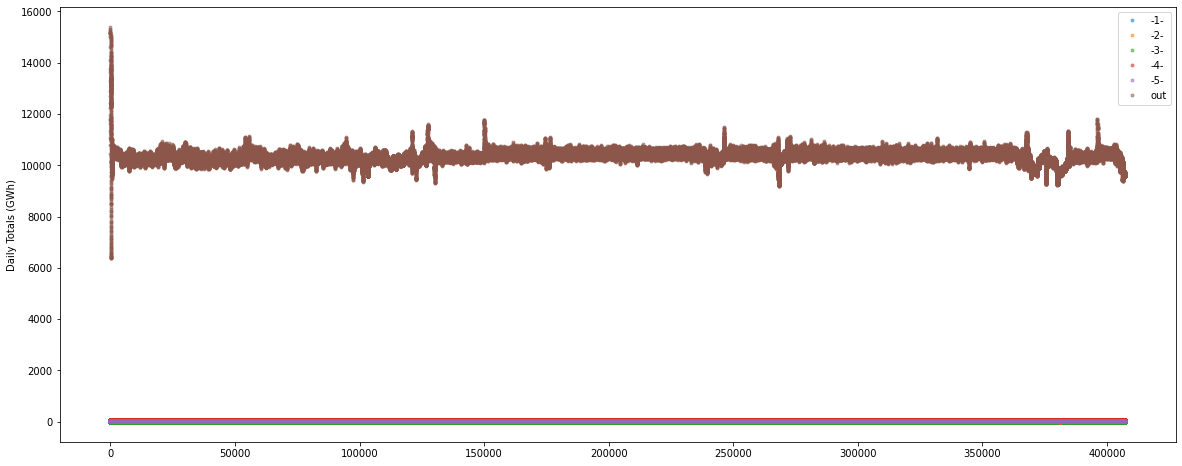

In [71]:
axes = time_series_df.plot(marker='.', alpha=0.5, linestyle='None')
plt.ylabel('Daily Totals (GWh)');

## Can we predict each day's consumption from its past?

### We train on the years 2006 - 2016 and validate on 2017

In [72]:
# consumption = time_series_df['Consumption'].to_numpy()
consumption = time_series_df['-1-'].to_numpy()

consumption.shape

(407253,)

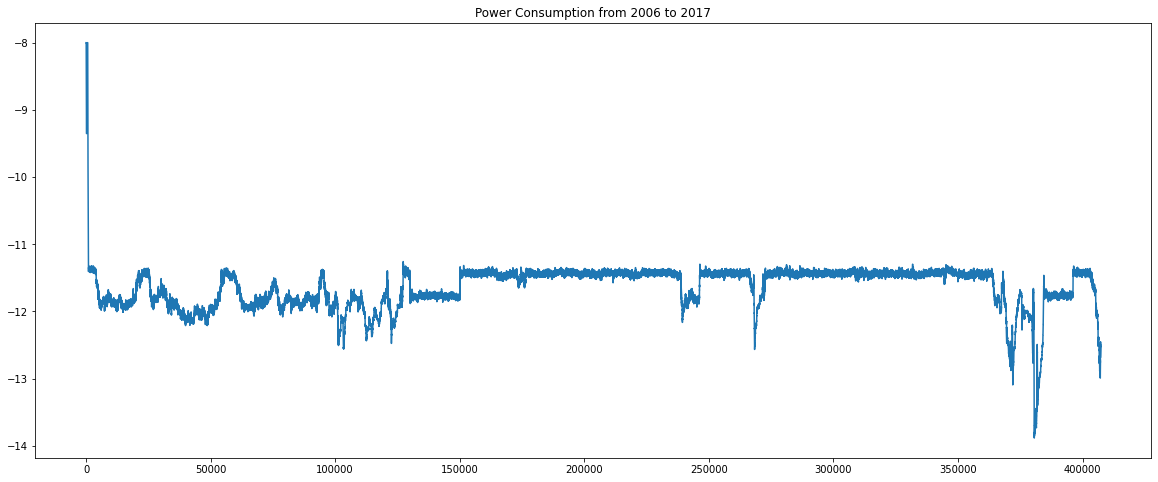

In [73]:
plt.title('Power Consumption from 2006 to 2017')
plt.plot(consumption);

## Statistical Methods directly geared towards forecasting

_Statistical Methods are often favorable: https://twitter.com/togelius/status/1173272424177119233_

* https://machinelearningmastery.com/time-series-forecasting-methods-in-python-cheat-sheet/
* https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b#targetText=Time%20series%20forecasting%20is%20the,forecasting%20retail%20sales%20time%20series.
* https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
* https://research.fb.com/prophet-forecasting-at-scale/

https://www.statsmodels.org
* https://www.statsmodels.org/stable/examples/index.html#stats
* https://www.statsmodels.org/stable/examples/notebooks/generated/tsa_arma_0.html
* https://www.statsmodels.org/stable/tsa.html



In [74]:
# import statsmodels.api as sm

# decomposition = sm.tsa.seasonal_decompose(time_series_df['out'], model='additive')
# decomposition.plot();

In [75]:
# derived from here: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

### How much of the past would we like for each individual prediction?

In [76]:
#@title Prediction from n past days

# https://colab.research.google.com/notebooks/forms.ipynb

n_steps_in = 30 #@param {type:"slider", min:1, max:100, step:1}
n_steps_out = 1

In [77]:
X, Y = split_sequence(consumption, n_steps_in, n_steps_out)
X.shape, Y.shape

((407223, 30), (407223, 1))

In [78]:
X[0], Y[0]

(array([-8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
        -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8., -8.,
        -8., -8., -8., -8.]), array([-8.]))

In [79]:
# reshape from [samples, timesteps] to [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
X.shape

(407223, 30, 1)

In [116]:
# we do a special test / train split, 
# we see how well we can predict 2017 as test/validation 


X_train = X[:-5840]
Y_train = Y[:-5840]

X_test = X[-120000:]
Y_test = Y[-120000:]

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((401383, 30, 1), (401383, 1), (120000, 30, 1), (120000, 1))

## Baslines

### R2 Metric: MSE and MAE are not speaking

* R^2 score, the closer to 1 the better
* loosely speaking: how much better is this than predicting the constant mean
* 0 would mean just as good
* 1 is perfect
* neg. would mean even worse
* it can become arbitrarily worse

https://en.wikipedia.org/wiki/Coefficient_of_determination


### Rolling mean baseline

In [117]:
def rolling_mean_baseline(history):
  return np.mean(history, axis=1)

In [118]:
Y_pred_baseline_rolling = rolling_mean_baseline(X)
Y_pred_baseline_rolling.shape

(407223, 1)

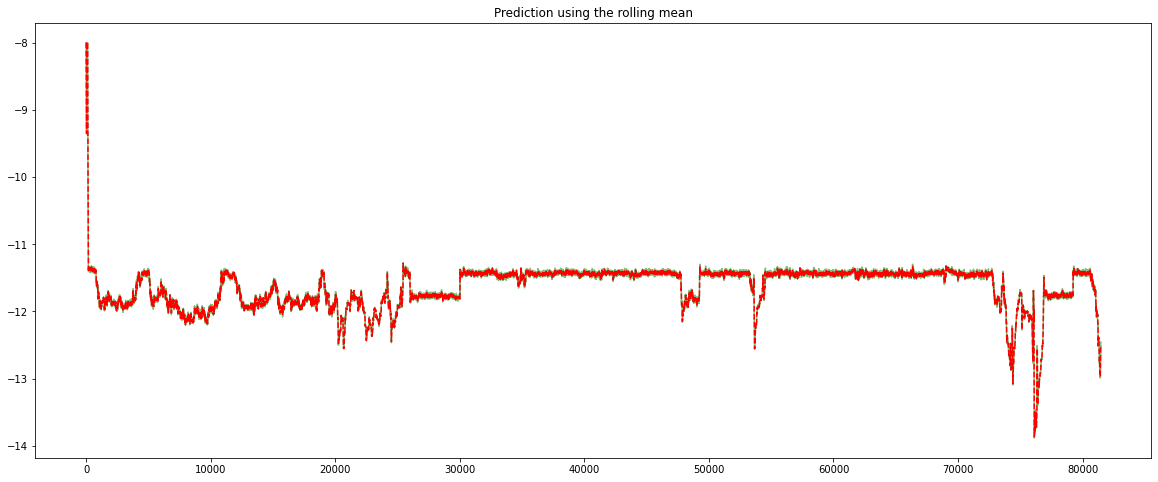

In [119]:
# this gets really crowded, using a stride, makes it more readable
stride = 5


plt.plot(consumption[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline_rolling[::stride], color='r', ls='dashed')

plt.title('Prediction using the rolling mean');


In [120]:
from sklearn.metrics import r2_score

r2_score(Y, Y_pred_baseline_rolling)

0.9964798991066087

### Baseline: Previous Value

In [121]:
def previous_value_baseline(history):
  return history[:, -1]

In [122]:
Y_pred_baseline_previous_value = previous_value_baseline(X)
Y_pred_baseline_previous_value.shape

(407223, 1)

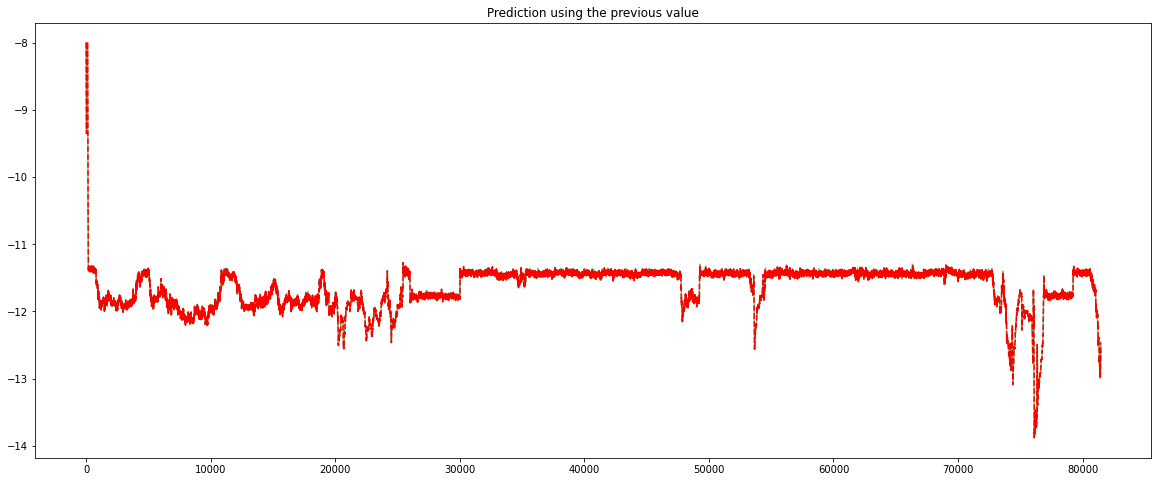

In [123]:
# this gets really crowded, using a stride, makes it more readable
stride = 5


plt.plot(consumption[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline_previous_value[::stride], color='r', ls='dashed')
plt.title('Prediction using the previous value');

### This looks good at first sight, but wait for the R2 score

It is (obviously) always off by one

In [124]:
from sklearn.metrics import r2_score

r2_score(Y, Y_pred_baseline_previous_value)

0.9992229047389355

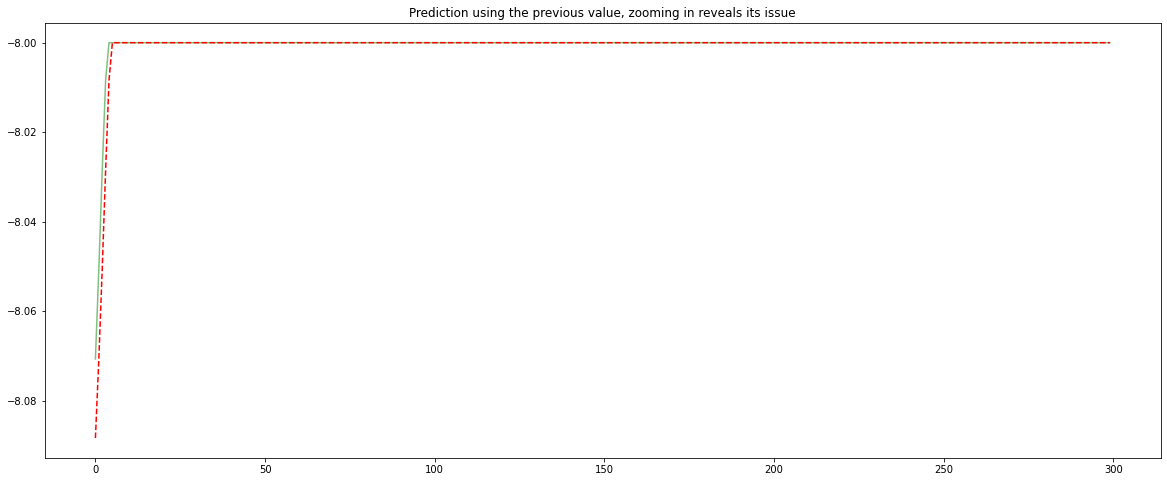

In [125]:
# this gets really crowded, using a stride, makes it more readable
stride = 1
# too crwoded, zoom in
window_start = 300
window_end = 600

plt.plot(consumption[n_steps_in+window_start:n_steps_in+window_end:stride], alpha=0.5, color='g')
plt.plot(Y_pred_baseline_previous_value[window_start:window_end:stride], color='r', ls='dashed')

plt.title('Prediction using the previous value, zooming in reveals its issue');

## Prediction using RNNs and TensorFlow

### Can we beat an r2 score around .20?

In [126]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [127]:
import tensorflow as tf
print(tf.__version__)

2.4.1


### Just for the reference, what GPU are we running on?

In [128]:
# What kind of GPU are we running on
!nvidia-smi

Sun Apr 25 18:36:13 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    24W /  75W |    283MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [129]:
# adapted from https://stackoverflow.com/a/42351397/1756489 and ported to TF 2
# https://keras.io/metrics/#custom-metrics

# only works on tensors while training, use sklearn version when using on numpy arrays

def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, total_error))
  
  return R_squared

### Training our model

In [130]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model

model = Sequential()

# two layer model, known to work well
# model.add(GRU(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(GRU(100, activation='relu'))

# trains faster, but also works
# model.add(GRU(256, activation='relu', input_shape=(n_steps_in, n_features)))

# one layer SimpleRNN seems to be enough for this data set
model.add(SimpleRNN(256, activation='relu', input_shape=(n_steps_in, n_features)))

# horrible results
# model.add(LSTM(256, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
# model.add(LSTM(64, activation='relu'))

# optional regularization
# model.add(BatchNormalization())
# model.add(Dropout(0.2))


# combines final outputs from RNN into continous output
model.add(Dense(n_steps_out))

model.compile(optimizer='adam', loss='mse', metrics=[r2_metric])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 256)               66048     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 66,305
Trainable params: 66,305
Non-trainable params: 0
_________________________________________________________________


In [131]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((401383, 30, 1), (401383, 1), (120000, 30, 1), (120000, 1))

In [132]:
%%time

batch_size = 32
epochs=25

history = model.fit(X_train, Y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(X_test, Y_test),
                    verbose=1)

Epoch 1/25
12544/12544 [==============================] - 215s 17ms/step - loss: 0.2501 - r2_metric: -1.6970 - val_loss: 0.0017 - val_r2_metric: -17.4574
Epoch 2/25
12544/12544 [==============================] - 215s 17ms/step - loss: 9.5312e-04 - r2_metric: 0.9867 - val_loss: 2.1546e-04 - val_r2_metric: -1.4005
Epoch 3/25
12544/12544 [==============================] - 214s 17ms/step - loss: 4.6210e-04 - r2_metric: 0.9936 - val_loss: 5.1237e-04 - val_r2_metric: -4.5922
Epoch 4/25
12544/12544 [==============================] - 215s 17ms/step - loss: 3.6009e-04 - r2_metric: 0.9953 - val_loss: 8.3691e-05 - val_r2_metric: 0.3809
Epoch 5/25
12544/12544 [==============================] - 218s 17ms/step - loss: 2.6711e-04 - r2_metric: 0.9963 - val_loss: 8.1763e-05 - val_r2_metric: 0.3968
Epoch 6/25
12544/12544 [==============================] - 218s 17ms/step - loss: 2.2914e-04 - r2_metric: 0.9968 - val_loss: 4.1758e-04 - val_r2_metric: -3.9466
Epoch 7/25
12544/12544 [========================

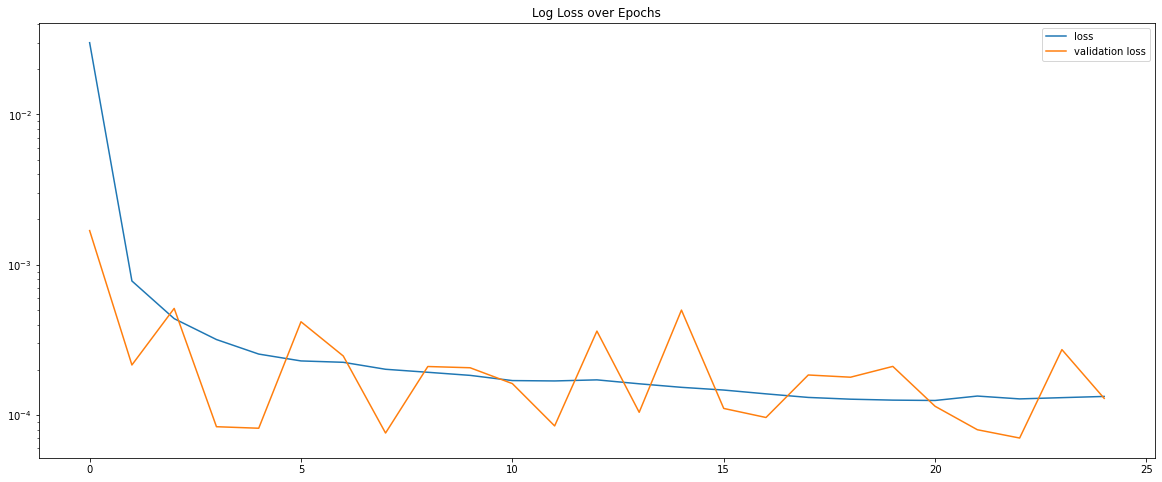

In [133]:
plt.yscale('log')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Log Loss over Epochs')

plt.legend(['loss', 'validation loss']);

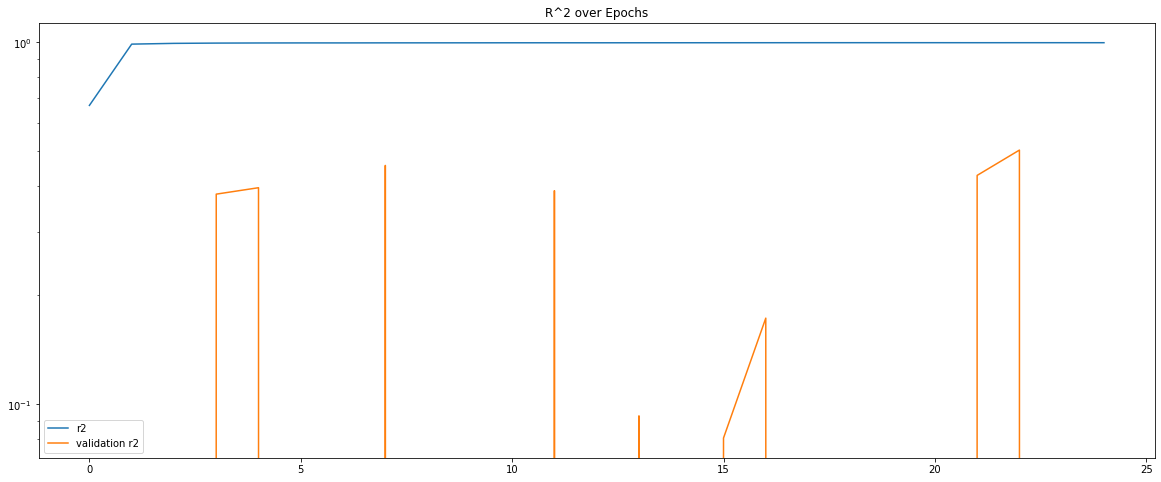

In [134]:
plt.yscale('log')
plt.plot(history.history['r2_metric'])
plt.plot(history.history['val_r2_metric'])
plt.title('R^2 over Epochs')

plt.legend(['r2', 'validation r2']);

In [135]:
model.evaluate(X, Y, batch_size=batch_size, verbose=0)

[0.000124473255709745, -inf]

### R2 for all data

In [136]:
from sklearn.metrics import r2_score

Y_pred = model.predict(X)
r2_score(Y, Y_pred)

0.9988580743298674

### R2 for training data

In [137]:
Y_train_pred = model.predict(X_train)
r2_score(Y_train, Y_train_pred)

0.9988405718976439

### R2 for validation data

In [138]:
Y_test_pred = model.predict(X_test)
r2_score(Y_test, Y_test_pred)

0.9991686284236159

## Let's plot predicted and true over each other

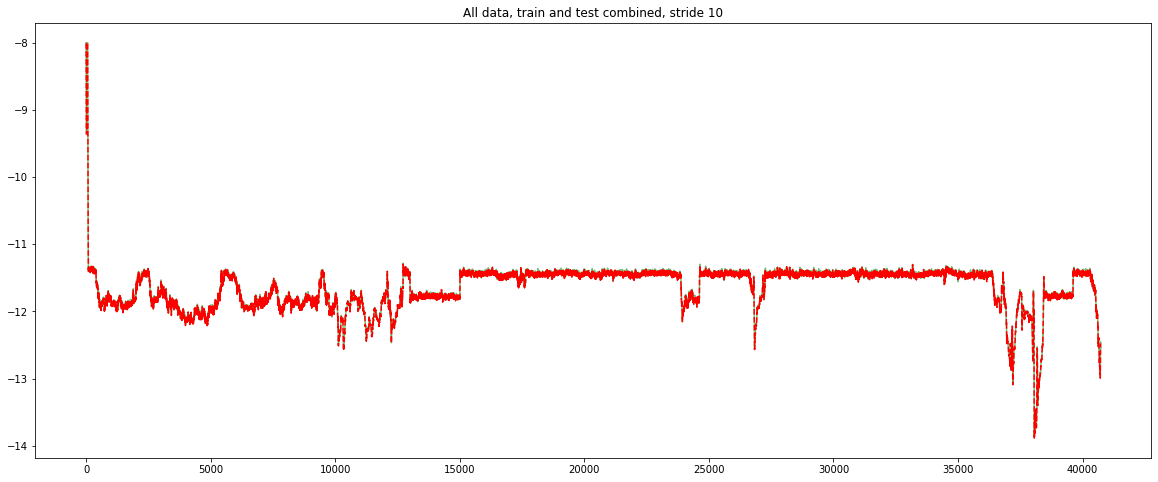

In [139]:
# this gets really crowded, using a stride, makes it more readable
stride = 10

# for the first 90 days we have no prediction, so get rid of them
plt.plot(consumption[n_steps_in::stride], alpha=0.5, color='g')
plt.plot(Y_pred[::stride], color='r', ls='dashed')

plt.title('All data, train and test combined, stride 10');


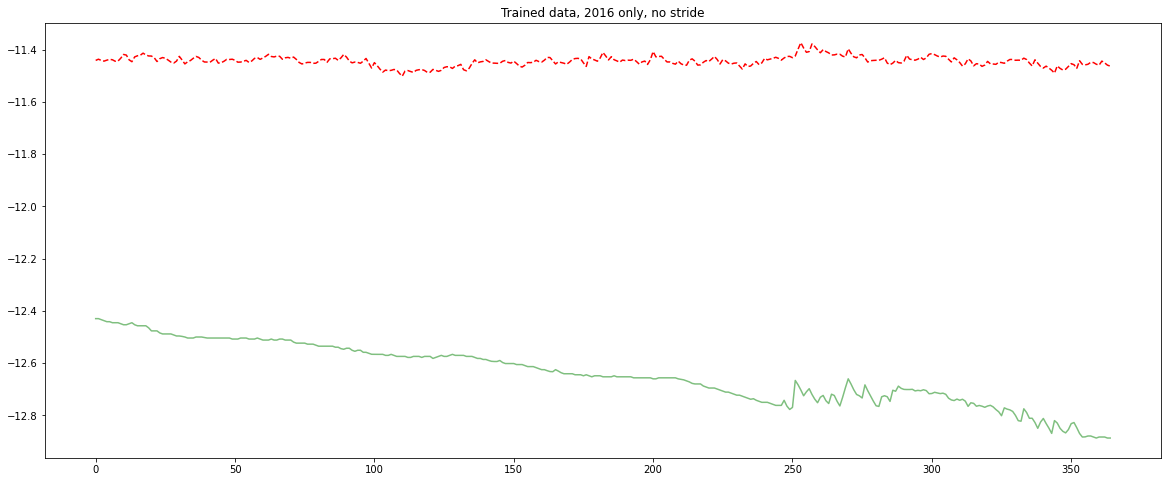

In [140]:
stride = 1


plt.plot(consumption[-2 * 365:-365:stride], alpha=0.5, color='g')
plt.plot(Y_train_pred[-365::stride], color='r', ls='dashed')

plt.title('Trained data, 2016 only, no stride');


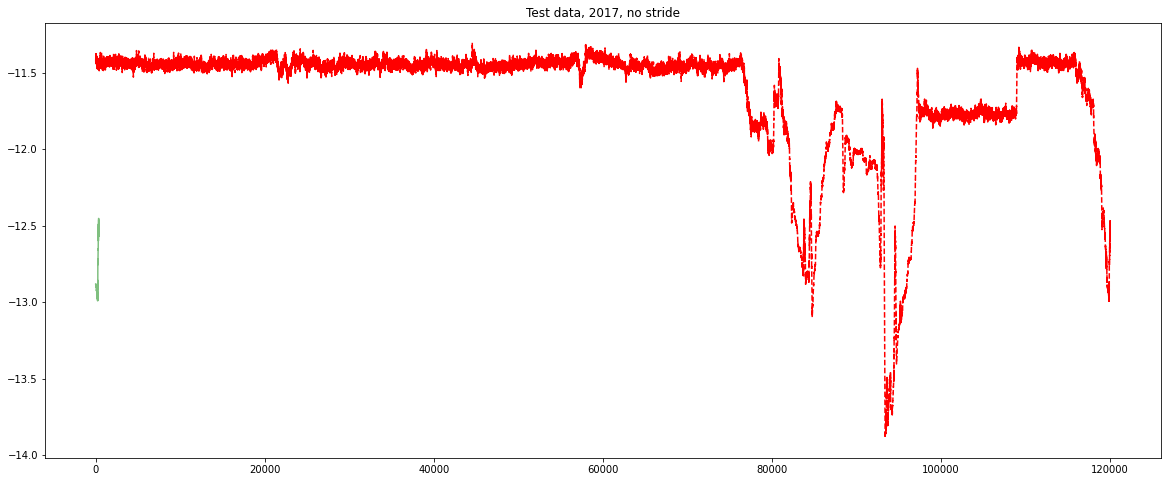

In [141]:
stride = 1


plt.plot(consumption[-365::stride], alpha=0.5, color='g')
plt.plot(Y_test_pred[::stride], color='r', ls='dashed')

plt.title('Test data, 2017, no stride');


## Observation / Wrap-Up

### overall a pretty good result
* r2 score is pretty promising
* defintely improved over baseline
* no domain knowledge necessary

### no dramatic difference between training and test data
* neither in metrices
* nor in visual inspection

### peaks and valleys are underestimated very often
* but often the most interesting part
* this seems to be a common problem in time series prediction
* it gets better we train the model for longer
* also when we increase its capacity
* on the other hand this might counter regularization


## Next Steps
  
### make use of seasonal decomposition
* predict each of the components
  * trend should be pretty easy
  * residual shows clear spices on national holidays
  * remove them
  * the results might be noise only
  * but maybe it is not, train a model on it to check
  
### have a more powerful statistical baseline
* Use more powerful statistical models
  * https://www.statsmodels.org/stable/tsa.html
  * http://www.statsmodels.org/dev/tsa.html
  * http://www.statsmodels.org/dev/vector_ar.html
* MSBVAR (Markov-Switching, Bayesian, Vector Autoregression Models) might beat our model, but
  * needs a lot of modelling 
  * does not seem readily available in the Python world (in R it would be)
  
